[View in Colaboratory](https://colab.research.google.com/github/kritiyer/mydeeplabdemo/blob/master/mydeeplab.ipynb)

In [0]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

#imports for google drive
from google.colab import auth, files
#auth.authenticate_user()
#from googleapiclient.discovery import build
#from httplib2 import Http
#from oauth2client import file, client, tools

In [0]:
##@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 572
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()
    
    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  #colormap = np.zeros((256, 3), dtype=int)
  #ind = np.arange(256, dtype=int)

  #for shift in reversed(range(8)):
  #  for channel in range(3):
  #    colormap[:, channel] |= ((ind >> channel) & 1) << shift
  #  ind >>= 3

  #return colormap
  return np.asarray([
      [0,0,0],
      [255,255,255]
      
  ])


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'vessel'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

#My Deeplab model fileID in google drive
1pxx7S_u1V7wH1d0rYTOaY_DOxq-1Pbcx (tar.gz) 

1b-tvrrLeiSPdTmAVNDXl4YqEpbM_ZltA (.pb protobuf)

In [5]:
#@title Upload tar file
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
upload_files()

Saving frozen_inference_graph.tar.gz to frozen_inference_graph.tar.gz


['frozen_inference_graph.tar.gz']

In [6]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'mydeeplab_2200'  # @param ['mydeeplab_2200', 'mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']


MODEL = DeepLabModel('frozen_inference_graph.tar.gz')
print('model loaded successfully!')

model loaded successfully!


# **Run on sample images**
Select one of sample images (leave IMAGE_URL empty) or feed any internet image url for inference.

Note that we are using single scale inference in the demo for fast computation, so the results may slightly differ from the visualizations in README, which uses multi-scale and left-right flipped inputs.

In [9]:
#@title upload sample image
upload_files()

Saving L1011-1-25.png to L1011-1-25.png


['L1011-1-25.png']

running deeplab on image L1011-1-25.png...


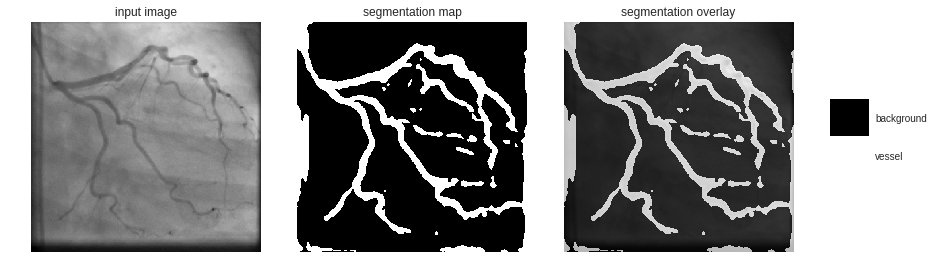

In [15]:
#@title Run on sample images {display-mode: "form"}

IMAGE_URL = 'L1011-1-25.png'  #@param {type:"string"}

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(IMAGE_URL)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL
run_visualization(image_url)